In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

In [2]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [3]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

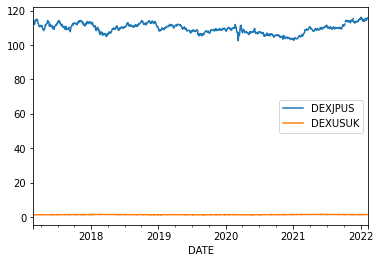

In [4]:
ccy_data.plot();

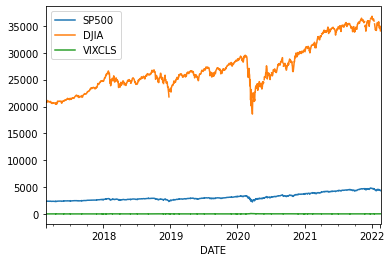

In [5]:
idx_data.plot();

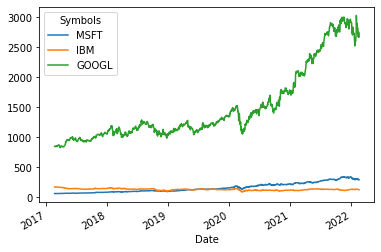

In [6]:
stk_data['Open'].plot();

In [7]:
return_period = 5

In [8]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

In [9]:
Y.name = 'MSFT_pred'

In [10]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, 
                                                                            return_period * 3, 
                                                                            return_period * 6, 
                                                                            return_period * 12]
          ], axis=1).dropna()

X = pd.concat([X1,X2,X3,X4], axis=1)

dataset = pd.concat([X,Y], axis=1).dropna().iloc[::return_period, :]

In [11]:
dataset

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,"(Adj Close, MSFT)","(Adj Close, MSFT)","(Adj Close, MSFT)","(Adj Close, MSFT)",MSFT_pred
2017-05-17,-0.013358,-0.002118,-0.022708,0.000386,-0.017912,-0.016182,0.423262,-0.021042,0.000542,0.031992,0.051037,0.018936
2017-05-24,0.036925,0.010414,0.005012,-0.000696,0.019894,0.019486,-0.442047,0.018936,0.001218,0.054738,0.077913,0.019155
2017-06-01,0.010865,0.001049,-0.004127,-0.004643,0.006188,0.002900,-0.010060,0.019155,0.017050,0.080636,0.090525,0.026048
2017-06-09,-0.026448,0.013392,0.001085,-0.011553,-0.002997,0.003092,0.092976,-0.020271,0.037823,0.035302,0.088238,-0.004561
2017-06-16,-0.011925,0.008272,0.002077,0.003214,0.000567,0.005266,-0.030363,-0.004561,0.005443,0.022862,0.079362,0.017138
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,-0.059557,0.010622,0.005283,0.002885,-0.017453,-0.004450,0.123601,-0.077933,-0.064074,-0.073088,0.071076,-0.029355
2022-01-14,0.017820,-0.004609,-0.014989,0.006385,-0.003036,-0.008867,0.022662,-0.012303,-0.075987,-0.060329,0.010863,-0.045609
2022-01-25,-0.068965,0.023492,-0.006303,-0.006868,-0.049410,-0.030742,0.312813,-0.047917,-0.148724,-0.171728,-0.115335,0.067904
2022-02-01,0.080995,-0.004197,0.007785,0.000741,0.042709,0.031781,-0.349913,0.067904,-0.017688,-0.047562,-0.084028,-0.013696
